In [1]:
"This notebook is for calculating single cell RNA velocity with Dynamo."

'This notebook is for calculating single cell RNA velocity with Dynamo.'

In [2]:
import dynamo as dyn
import numpy as np
from scipy import stats,signal
from matplotlib import pyplot as plt
from scipy import sparse
from sklearn.neighbors import KernelDensity
import networkx as nx
import os
from numpy.random import randint    

/home/linux/miniforge3/envs/FISHER/lib/python3.9/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/linux/miniforge3/envs/FISHER/lib/python3.9/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/linux/miniforge3/envs/FISHER/lib/python3.9/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
 

In [3]:
# data_name = "EG_ab_bin1"
# data_name = "DG_bin_ppt"
data_name = "zebrafish_dynamo_part"
# data_name = "zebrafish_dynamo_C_6_282_cs_cut_0.65"

# NOTE: 虽然这里有K和L，但就是一个文件名，对运行结果没影响，没有gaussian embedding的事情。
result_path=f'result/{data_name}/'
data_path = "/home/linux/桌面/SCIM-main/main/data/branch_data/"
# data_path = "/home/linux/桌面/Is single cell sloppy?/7_data_preprocess/results/"

if not os.path.exists(f'{result_path}'):
    os.makedirs(f'{result_path}')

# gene_arr=np.load(result_path+'EG_bin_genes.npy',allow_pickle=True)
dim_n=10
# data_name = "DG_bin_ppt"
# adata=dyn.read(f'/home/linux/桌面/SCIM-main/main/data/branch_data/{data_name}.h5ad')
adata=dyn.read(f'{data_path}{data_name}.h5ad')
# t_list=['Schwann Cell', 'Schwann Cell Precursor', 'Proliferating Progenitor', 'Pigment Progenitor', 'Xanthophore']
print(adata)

AnnData object with n_obs × n_vars = 3386 × 600
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'celltype', 'umap_1', 'umap_2', 'batch', 'n_counts'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'


/home/linux/miniforge3/envs/FISHER/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [4]:
cluster = "Cell_type"
adata.obs.rename(columns={"celltype": cluster}, inplace=True)

In [5]:
# print(adata.obs["ClusterName"].unique()) # DG
# print(adata.obs["clusters"].unique())  # EG
print(adata.obs[cluster].unique())  # zebrafish

['Schwann Cell', 'Melanophore', 'Schwann Cell Precursor', 'Proliferating Progenitor', 'Xanthophore', 'Pigment Progenitor', 'Other Glia']
Categories (7, object): ['Melanophore', 'Other Glia', 'Pigment Progenitor', 'Proliferating Progenitor', 'Schwann Cell', 'Schwann Cell Precursor', 'Xanthophore']


/home/linux/miniforge3/envs/FISHER/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


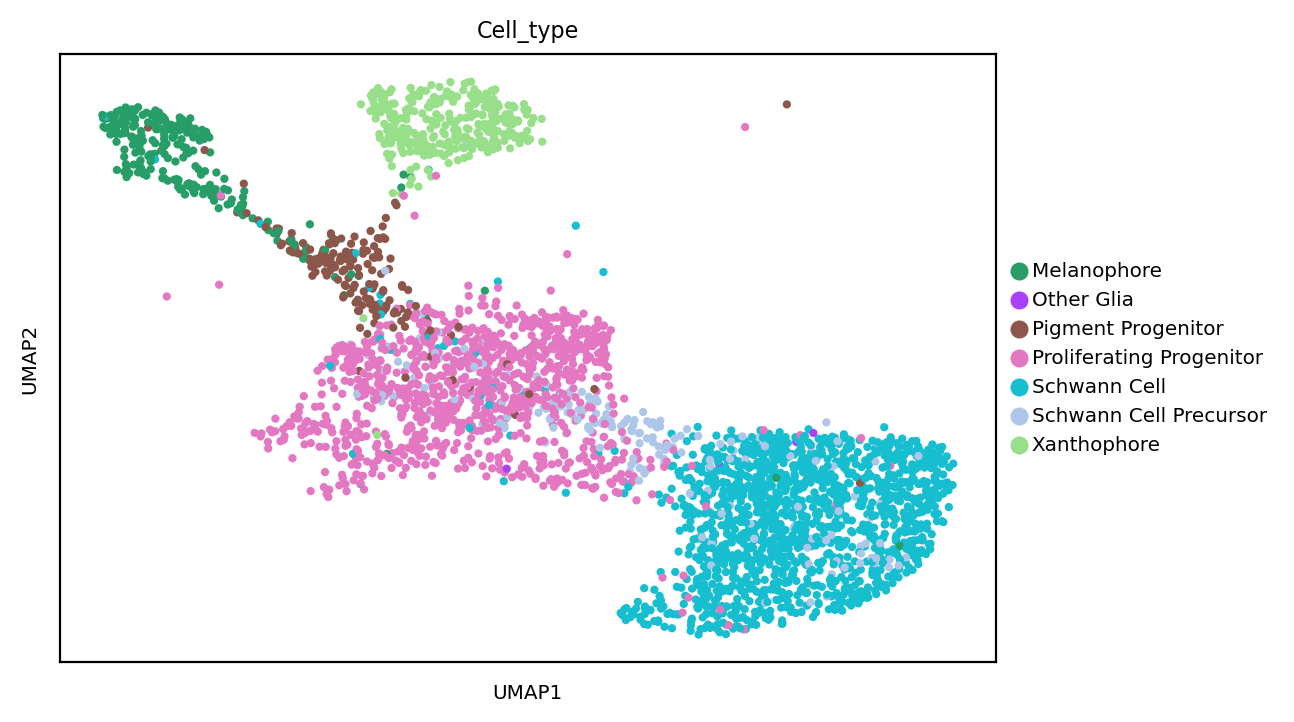

In [6]:
import scanpy as sc
sc.pl.umap(adata, color=cluster)

|-----? dynamo.preprocessing.deprecated is deprecated.
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labeling data properly collapased
|-----? dynamo detects your data is size factor normalized and/or log transformed. If this is not right, plese set `normalized = False.
|-----> filtering cells...
|-----> 3079 cells passed basic filters.
|-----> filtering gene...
|-----> 135 genes passed basic filters.
|-----> calculating size factor...
|-----? only 135 genes passed basic filtering, but you requested 2000 genes for feature selection. Try lowering the gene selection stringency: {'min_expr_cells': 0, 'min_expr_avg': 0, 'max_expr_avg': inf, 'svr_gamma': None, 'winsorize': False, 'winsor_perc': (1, 99.5), 'sort_inverse':

/tmp/ipykernel_556682/2890445507.py:1: DeprecationWarning: recipe_monocle is deprecated and will be removed in a future release. Please update your code to use the new replacement function.
  dyn.pp.recipe_monocle(adata,keep_filtered_genes=False,keep_filtered_cells=True)


|-----> Discarding genes that failed the filtering...
|-----> applying PCA ...
|-----> <insert> X_pca to obsm in AnnData Object.
|-----> cell cycle scoring...
|-----> computing cell phase...
|-----? 
Dynamo is not able to perform cell cycle staging for you automatically. 
Since dyn.pl.phase_diagram in dynamo by default colors cells by its cell-cycle stage, 
you need to set color argument accordingly if confronting errors related to this.
|-----> [recipe_monocle preprocess] completed [0.1433s]
|-----> dynamics_del_2nd_moments_key is None. Using default value from DynamoAdataConfig: dynamics_del_2nd_moments_key=False
|-----------> removing existing M layers:[]...
|-----------> making adata smooth...
|-----> calculating first/second moments...
|-----? layer X_Mu is not in any of the (['X_spliced', 'X_unspliced'], ['X_new', 'X_total'], ['X_uu', 'X_ul', 'X_su', 'X_sl']) groups, skipping...
|-----? layer X_Ms is not in any of the (['X_spliced', 'X_unspliced'], ['X_new', 'X_total'], ['X_uu', 

estimating gamma: 100%|██████████| 600/600 [00:03<00:00, 171.80it/s]


|-----> retrieve data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [UMAP] completed [0.0005s]
|-----------> plotting with basis key=X_umap
|-----------> skip filtering Cell_type by stack threshold when stacking color because it is not a numeric type


/home/linux/miniforge3/envs/FISHER/lib/python3.9/site-packages/dynamo/tools/utils.py:1443: RuntimeWarning: divide by zero encountered in divide
  adata.var.loc[valid_ind, kin_param_pre + "half_life"] = None if gamma is None else np.log(2) / gamma


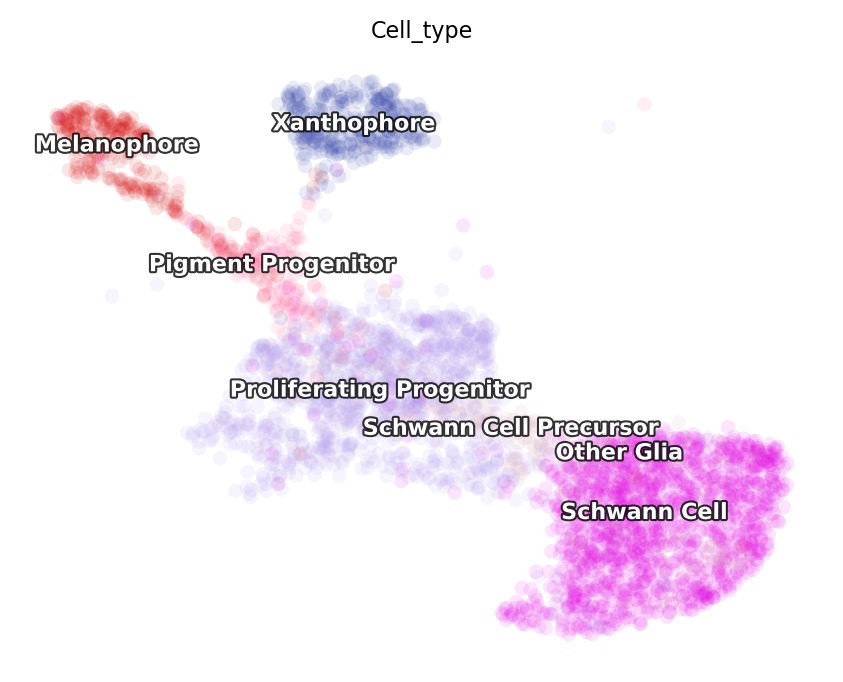

In [7]:
dyn.pp.recipe_monocle(adata,keep_filtered_genes=False,keep_filtered_cells=True)

dyn.tl.dynamics(adata,assumption_mRNA='auto')
dyn.tl.reduceDimension(adata, n_pca_components=50)
dyn.pl.umap(adata, color=cluster,pointsize=0.1)

In [8]:
dyn.tl.cell_velocities(adata, method='fp',basis='pca',  correct_density=False)#ekey='M_s',vkey='velocity_S',

/home/linux/miniforge3/envs/FISHER/lib/python3.9/site-packages/dynamo/tools/utils.py:2258: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(adata.var.gamma_r2.values is None) or np.all(adata.var.gamma_r2.values == ""):


|-----> [projecting velocity vector to low dimensional embedding] in progress: 53.2191%

/home/linux/miniforge3/envs/FISHER/lib/python3.9/site-packages/dynamo/tools/Markov.py:965: RuntimeWarning: invalid value encountered in divide
  self.Q[:, i] /= np.sum(self.Q[:, i])


|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%|-----> [projecting velocity vector to low dimensional embedding] completed [0.2108s]


AnnData object with n_obs × n_vars = 3386 × 600
    obs: 'split_id', 'sample', 'Size_Factor', 'condition', 'Cluster', 'Cell_type', 'umap_1', 'umap_2', 'batch', 'n_counts', 'nGenes', 'nCounts', 'pMito', 'pass_basic_filter', 'ntr'
    var: 'n_cells', 'gene_count_corr', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'nCells', 'nCounts', 'pass_basic_filter', 'frac', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'bs', 'bf', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'Cell_type_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap', 'pp', 'PCs', 'explained_variance_ratio_', 'pca_mean', 'pca_fit', 'feature_selection', 'dynamics', 'grid_velocity_pca'
    obsm: 'X_pca', 'X_umap', 'X', 'velocity_pca'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'X_unspliced', 'X_Mu', 'X_Ms', 'X_spliced', 'M_u', 'M_uu', 'M_s', 'M_us', 'M

In [9]:
adata.layers["velocity_S"].shape

(3386, 600)

In [10]:
adata.obsm["X_pca"].shape

(3386, 30)

In [11]:
adata.obsm["velocity_pca"].shape

(3386, 30)

In [12]:
adata.obsm["velocity_pca"]

array([[-0.14358314,  0.00873332, -0.0210705 , ...,  0.12196945,
        -0.10756131, -0.07886306],
       [-0.02003455,  0.13801312,  0.24449432, ...,  0.03588862,
        -0.10968556,  0.0031183 ],
       [ 0.14223574,  0.06289652,  0.12836865, ...,  0.15443535,
         0.02014325,  0.08213803],
       ...,
       [ 0.25811955, -0.25484753, -0.24576788, ..., -0.07849172,
         0.02453143, -0.03444734],
       [-0.0036855 , -0.00706118,  0.04166667, ..., -0.10320934,
        -0.03492392,  0.03993347],
       [ 0.00098766, -0.03283773,  0.03265328, ...,  0.0626807 ,
         0.2710342 , -0.03072991]])

In [13]:
print(adata.layers["velocity_S"])

  (0, 0)	-7.240828896713656e-05
  (0, 1)	-3.1247643671617775e-06
  (0, 2)	-0.00033903443789852966
  (0, 3)	-4.203125247721982e-06
  (0, 4)	-0.002071582512626388
  (0, 5)	-2.3408797059421184e-05
  (0, 6)	0.019967057547118035
  (0, 7)	0.02804422954015987
  (0, 8)	-0.0008127886638903614
  (0, 9)	0.011109040645974292
  (0, 10)	0.03791358872212586
  (0, 11)	-0.000404741141764941
  (0, 12)	-0.0039123323539371115
  (0, 13)	0.41884597180130334
  (0, 14)	-0.0008398931290878407
  (0, 15)	-1.170593768441165e-06
  (0, 16)	0.0091962980907758
  (0, 17)	-0.0015921126959292842
  (0, 18)	-3.739549635913879e-06
  (0, 19)	-0.0014628936109769822
  (0, 20)	-5.3876476203201635e-06
  (0, 21)	0.0767436771573804
  (0, 22)	0.024737951980614736
  (0, 23)	-0.00012079879616624487
  (0, 24)	0.011234403839786213
  :	:
  (3385, 555)	0.0069191290254795946
  (3385, 556)	0.012569745228909754
  (3385, 557)	-0.000231821914489118
  (3385, 560)	0.016321285575088808
  (3385, 561)	0.0065805441699922085
  (3385, 562)	0.0522623

|-----------> plotting with basis key=X_pca
|-----------> skip filtering Cell_type by stack threshold when stacking color because it is not a numeric type


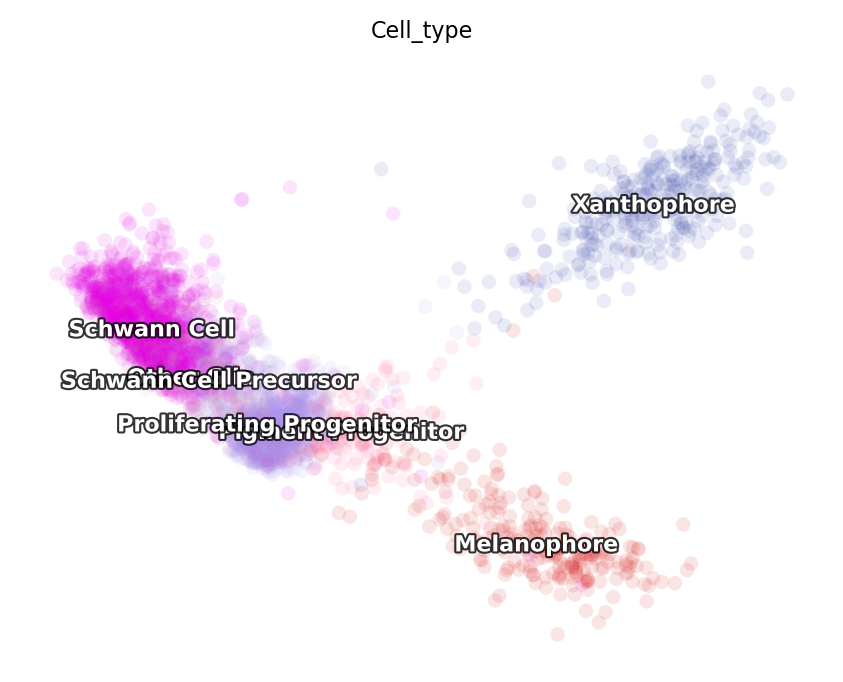

In [14]:
dyn.pl.pca(adata, color=cluster,pointsize=0.1)

In [15]:
print(adata.var.dtypes)

for col in adata.var.columns:
    if adata.var[col].dtype == object:  # 对象类型可能包含混合类型
        adata.var[col] = adata.var[col].astype(str)
        
from collections import OrderedDict

for key in list(adata.uns.keys()):
    if isinstance(adata.uns[key], OrderedDict):
        adata.uns[key] = dict(adata.uns[key])

n_cells                 int64
gene_count_corr       float64
highly_variable          bool
means                 float64
dispersions           float64
dispersions_norm      float32
nCells                  int64
nCounts               float32
pass_basic_filter        bool
frac                  float32
use_for_pca              bool
ntr                   float32
beta                  float64
gamma                 float64
half_life             float64
alpha_b                object
alpha_r2               object
gamma_b               float64
gamma_r2              float64
gamma_logLL           float64
delta_b                object
delta_r2               object
bs                    float64
bf                    float64
uu0                    object
ul0                    object
su0                    object
sl0                    object
U0                     object
S0                     object
total0                 object
use_for_dynamics         bool
use_for_transition       bool
dtype: obj

In [16]:
adata.write(result_path+f'{data_name}_fp.h5ad')

In [17]:
adata.obsm["velocity_pca"].shape

(3386, 30)